In [153]:
import os, random, math, time, re
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [171]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Final için öneri
EPOCHS = 2
BATCH  = 2
LR     = 5e-4

IMG_SIZE = 384   # 512 daha hızlı, 640 raf için daha iyi
SCALES   = [80, 40, 20]  # IMG_SIZE=640 için /8,/16,/32 grid

OBJ_POS_W = 2.0
OBJ_NEG_W = 1.0

CONF_THRESH = 0.60  # inference için
NMS_IOU     = 0.40

print("EPOCHS:", EPOCHS, "BATCH:", BATCH, "LR:", LR, "IMG_SIZE:", IMG_SIZE)


EPOCHS: 2 BATCH: 2 LR: 0.0005 IMG_SIZE: 384


In [172]:
BASE = Path(r"C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed")
IMG_ROOT = BASE / "images"
ANN_ROOT = BASE / "annotations"

IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}

if not BASE.exists():
    raise FileNotFoundError(f"BASE bulunamadı: {BASE}")
if not IMG_ROOT.exists():
    raise FileNotFoundError(f"images klasörü bulunamadı: {IMG_ROOT}")
if not ANN_ROOT.exists():
    raise FileNotFoundError(f"annotations klasörü bulunamadı: {ANN_ROOT}")

# Split klasörleri varsa onları al; yoksa tek klasör kabul et
TRAIN_IMG_DIR = IMG_ROOT/"train" if (IMG_ROOT/"train").exists() else IMG_ROOT
VAL_IMG_DIR   = IMG_ROOT/"val"   if (IMG_ROOT/"val").exists()   else None
TEST_IMG_DIR  = IMG_ROOT/"test"  if (IMG_ROOT/"test").exists()  else None

ANN_TRAIN = ANN_ROOT/"annotations_train.csv"
ANN_VAL   = ANN_ROOT/"annotations_val.csv"
ANN_TEST  = ANN_ROOT/"annotations_test.csv"

print("TRAIN_IMG_DIR:", TRAIN_IMG_DIR)
print("VAL_IMG_DIR  :", VAL_IMG_DIR)
print("TEST_IMG_DIR :", TEST_IMG_DIR)

print("ANN_TRAIN:", ANN_TRAIN.exists(), ANN_TRAIN)
print("ANN_VAL  :", ANN_VAL.exists(),   ANN_VAL)
print("ANN_TEST :", ANN_TEST.exists(),  ANN_TEST)

train_count = sum(1 for p in TRAIN_IMG_DIR.iterdir() if p.suffix.lower() in IMG_EXTS)
print("Train img sayısı:", train_count)
if train_count == 0:
    raise RuntimeError("TRAIN_IMG_DIR içinde görüntü yok. Klasör yolu yanlış.")


TRAIN_IMG_DIR: C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\images
VAL_IMG_DIR  : None
TEST_IMG_DIR : None
ANN_TRAIN: True C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\annotations\annotations_train.csv
ANN_VAL  : True C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\annotations\annotations_val.csv
ANN_TEST : True C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\annotations\annotations_test.csv
Train img sayısı: 11743


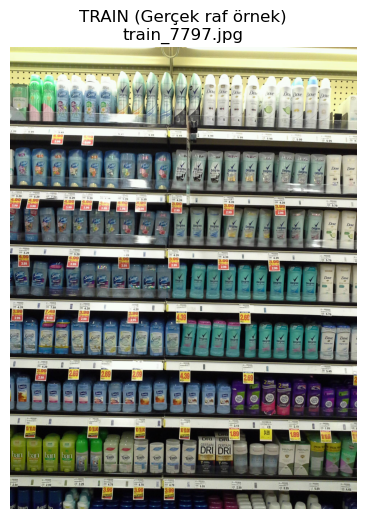

In [173]:
def show_random_image(img_dir: Path, title="Random image"):
    imgs = [p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS]
    if not imgs:
        print("❌ Görüntü yok:", img_dir)
        return
    p = random.choice(imgs)
    img = Image.open(p).convert("RGB")
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.title(f"{title}\n{p.name}")
    plt.axis("off")
    plt.show()

show_random_image(TRAIN_IMG_DIR, "TRAIN (Gerçek raf örnek)")


In [174]:
def parse_row_auto(line: str):
    line = line.strip()
    if not line:
        return None

    # virgül / boşluk ayırıcı
    if "," in line:
        parts = [p.strip() for p in line.split(",")]
    else:
        parts = line.split()

    # header satırı olabilir
    low = " ".join(parts).lower()
    if ("x1" in low or "xmin" in low or "ymin" in low or "image" in low) and any(ch.isalpha() for ch in low):
        return None

    # image adı: jpg/png geçen parça
    img_name = None
    for p in parts:
        if re.search(r"\.(jpg|jpeg|png|bmp|webp)$", p.lower()):
            img_name = p
            break
    if img_name is None and len(parts) >= 5:
        img_name = parts[0]

    # sayısalları çek
    nums = []
    for p in parts:
        try:
            nums.append(float(p))
        except:
            pass
    if len(nums) < 4 or img_name is None:
        return None

    # bbox: son 4 sayı (x1,y1,x2,y2)
    x1,y1,x2,y2 = nums[-4], nums[-3], nums[-2], nums[-1]
    return img_name, x1,y1,x2,y2

def csv_to_yolo(csv_path: Path, img_dir: Path, out_lbl_dir: Path):
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV bulunamadı: {csv_path}")
    if not img_dir.exists():
        raise FileNotFoundError(f"Img dir bulunamadı: {img_dir}")

    out_lbl_dir.mkdir(parents=True, exist_ok=True)

    lines = csv_path.read_text(encoding="utf-8", errors="ignore").splitlines()
    lines = [ln.strip() for ln in lines if ln.strip()]

    # img -> boxes
    boxes = {}
    for ln in lines:
        parsed = parse_row_auto(ln)
        if parsed is None:
            continue
        img_name,x1,y1,x2,y2 = parsed
        boxes.setdefault(str(img_name), []).append((x1,y1,x2,y2))

    # img dosyalarını map'le
    img_files = [p for p in img_dir.iterdir() if p.suffix.lower() in IMG_EXTS]
    name_map = {p.name: p for p in img_files}
    stem_map = {p.stem: p for p in img_files}

    made = 0
    for key, bxs in boxes.items():
        p = name_map.get(key, None)
        if p is None:
            # bazen sadece stem tutulur
            p = stem_map.get(Path(key).stem, None) or stem_map.get(key, None)
        if p is None:
            continue

        W,H = Image.open(p).size
        out_lines = []
        for (x1,y1,x2,y2) in bxs:
            x1 = max(0, min(x1, W-1)); y1 = max(0, min(y1, H-1))
            x2 = max(0, min(x2, W-1)); y2 = max(0, min(y2, H-1))
            if x2 <= x1 or y2 <= y1:
                continue
            xc = ((x1+x2)/2)/W
            yc = ((y1+y2)/2)/H
            w  = (x2-x1)/W
            h  = (y2-y1)/H
            out_lines.append(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

        (out_lbl_dir/(p.stem + ".txt")).write_text("\n".join(out_lines))
        made += 1

    print(f"✅ {csv_path.name} -> {out_lbl_dir}  | label üretilen img: {made}")
    return made


In [175]:
YOLO_ROOT = BASE/"labels_yolo_auto"
TRAIN_LBL_DIR = YOLO_ROOT/"train"
VAL_LBL_DIR   = YOLO_ROOT/"val"
TEST_LBL_DIR  = YOLO_ROOT/"test"

made_tr = csv_to_yolo(ANN_TRAIN, TRAIN_IMG_DIR, TRAIN_LBL_DIR)
if VAL_IMG_DIR is not None and ANN_VAL.exists():
    made_va = csv_to_yolo(ANN_VAL, VAL_IMG_DIR, VAL_LBL_DIR)
else:
    made_va = 0
if TEST_IMG_DIR is not None and ANN_TEST.exists():
    _ = csv_to_yolo(ANN_TEST, TEST_IMG_DIR, TEST_LBL_DIR)

# hızlı kontrol
txts = list(TRAIN_LBL_DIR.glob("*.txt"))
print("Train txt sayısı:", len(txts))
if txts:
    print("Örnek txt:", txts[0])
    print("İlk 3 satır:\n", "\n".join(txts[0].read_text().splitlines()[:3]))

if made_tr == 0:
    raise RuntimeError("Hiç label üretilmedi. CSV formatı beklediğimiz gibi değil veya img isimleri eşleşmiyor.")


✅ annotations_train.csv -> C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\labels_yolo_auto\train  | label üretilen img: 8219
Train txt sayısı: 8219
Örnek txt: C:\Users\samet\OneDrive\Masaüstü\sku_samet\data\SKU110K_fixed\labels_yolo_auto\train\train_0.txt
İlk 3 satır:
 0 0.569610 0.634425 0.860119 0.730489
0 0.725529 0.865079 0.548280 0.269180
0 0.708333 0.857970 0.582672 0.283399


In [176]:
def resize_and_norm(img: Image.Image, size=IMG_SIZE):
    img = img.convert("RGB").resize((size,size))
    arr = np.array(img, dtype=np.float32)/255.0
    return torch.from_numpy(arr).permute(2,0,1)  # C,H,W

def read_yolo_txt(txt_path: Path):
    if txt_path is None or (not txt_path.exists()):
        return torch.zeros((0,4), dtype=torch.float32)
    lines = txt_path.read_text().strip().splitlines()
    if len(lines)==0:
        return torch.zeros((0,4), dtype=torch.float32)
    boxes=[]
    for ln in lines:
        p = ln.strip().split()
        if len(p)!=5: 
            continue
        _, xc,yc,w,h = map(float,p)
        x1 = xc-w/2; y1 = yc-h/2; x2 = xc+w/2; y2 = yc+h/2
        boxes.append([x1,y1,x2,y2])
    if not boxes:
        return torch.zeros((0,4), dtype=torch.float32)
    b = torch.tensor(boxes, dtype=torch.float32)
    return torch.clamp(b, 0.0, 1.0)

class YoloFolderDataset(Dataset):
    def __init__(self, img_dir: Path, lbl_dir: Path):
        self.img_dir = Path(img_dir)
        self.lbl_dir = Path(lbl_dir)
        self.images = sorted([p for p in self.img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Bozuk görseller için birkaç kez dene, yine olmazsa başka index’e kay
        for _ in range(6):
            p = self.images[idx]
            try:
                with Image.open(p) as im:
                    im = im.convert("RGB")
                    x = resize_and_norm(im, IMG_SIZE)
                boxes = read_yolo_txt(self.lbl_dir/(p.stem + ".txt"))
                return x, boxes, p.name
            except Exception as e:
                # bozuk dosya -> rastgele başka bir örneğe geç
                idx = random.randint(0, len(self.images)-1)

        # Çok nadir: üst üste bozuk gelirse boş örnek döndür (eğitim patlamasın)
        x = torch.zeros((3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
        boxes = torch.zeros((0,4), dtype=torch.float32)
        return x, boxes, "BROKEN_IMAGE_SKIPPED"

train_ds = YoloFolderDataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
val_ds   = YoloFolderDataset(VAL_IMG_DIR, VAL_LBL_DIR) if (VAL_IMG_DIR is not None and VAL_LBL_DIR.exists()) else None
N_TRAIN = 300
N_VAL = 80

from torch.utils.data import Subset

train_idx = np.random.choice(len(train_ds), size=min(N_TRAIN, len(train_ds)), replace=False)
train_small = Subset(train_ds, train_idx)

if val_ds is not None:
    val_idx = np.random.choice(len(val_ds), size=min(N_VAL, len(val_ds)), replace=False)
    val_small = Subset(val_ds, val_idx)
else:
    val_small = None

train_loader = DataLoader(train_small, batch_size=BATCH, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_small,  batch_size=BATCH, shuffle=False, num_workers=0, collate_fn=collate_fn) if val_small else None

print("✅ Subset train:", len(train_small), "| subset val:", (len(val_small) if val_small else 0))


✅ Subset train: 300 | subset val: 0


In [177]:
def box_iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a[...,0], a[...,1], a[...,2], a[...,3]
    bx1, by1, bx2, by2 = b[...,0], b[...,1], b[...,2], b[...,3]
    inter_x1 = torch.maximum(ax1, bx1)
    inter_y1 = torch.maximum(ay1, by1)
    inter_x2 = torch.minimum(ax2, bx2)
    inter_y2 = torch.minimum(ay2, by2)
    inter_w = torch.clamp(inter_x2 - inter_x1, min=0.0)
    inter_h = torch.clamp(inter_y2 - inter_y1, min=0.0)
    inter = inter_w * inter_h
    area_a = torch.clamp(ax2-ax1, min=0.0) * torch.clamp(ay2-ay1, min=0.0)
    area_b = torch.clamp(bx2-bx1, min=0.0) * torch.clamp(by2-by1, min=0.0)
    union = area_a + area_b - inter + 1e-9
    return inter / union

def xywh_to_xyxy(xywh):
    xc, yc, w, h = xywh[...,0], xywh[...,1], xywh[...,2], xywh[...,3]
    x1 = xc - w/2; y1 = yc - h/2; x2 = xc + w/2; y2 = yc + h/2
    return torch.stack([x1,y1,x2,y2], dim=-1).clamp(0,1)

def conv_bn_act(in_ch, out_ch, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, k, s, p, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.SiLU(inplace=True)
    )


In [178]:
class TinyBackbone(nn.Module):
    def __init__(self, c=32):
        super().__init__()
        self.stem = conv_bn_act(3, c, 3, 2, 1)      # /2
        self.b1   = conv_bn_act(c, c, 3, 1, 1)

        self.d2   = conv_bn_act(c, c*2, 3, 2, 1)    # /4
        self.b2   = conv_bn_act(c*2, c*2, 3, 1, 1)

        self.d3   = conv_bn_act(c*2, c*4, 3, 2, 1)  # /8  -> C3
        self.b3   = conv_bn_act(c*4, c*4, 3, 1, 1)

        self.d4   = conv_bn_act(c*4, c*6, 3, 2, 1)  # /16 -> C4
        self.b4   = conv_bn_act(c*6, c*6, 3, 1, 1)

        self.d5   = conv_bn_act(c*6, c*8, 3, 2, 1)  # /32 -> C5
        self.b5   = conv_bn_act(c*8, c*8, 3, 1, 1)

    def forward(self, x):
        x  = self.b1(self.stem(x))
        x  = self.b2(self.d2(x))
        c3 = self.b3(self.d3(x))
        c4 = self.b4(self.d4(c3))
        c5 = self.b5(self.d5(c4))
        return c3, c4, c5

class TinyFPN(nn.Module):
    def __init__(self, c3, c4, c5, f=128):
        super().__init__()
        self.l3 = nn.Conv2d(c3, f, 1)
        self.l4 = nn.Conv2d(c4, f, 1)
        self.l5 = nn.Conv2d(c5, f, 1)
        self.p3 = conv_bn_act(f, f, 3, 1, 1)
        self.p4 = conv_bn_act(f, f, 3, 1, 1)
        self.p5 = conv_bn_act(f, f, 3, 1, 1)

    def forward(self, c3, c4, c5):
        p5 = self.l5(c5)
        p4 = self.l4(c4) + F.interpolate(p5, size=c4.shape[-2:], mode="nearest")
        p3 = self.l3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode="nearest")
        return self.p3(p3), self.p4(p4), self.p5(p5)

class DetectHead(nn.Module):
    def __init__(self, f=128):
        super().__init__()
        self.h3 = nn.Sequential(conv_bn_act(f,f,3,1,1), nn.Conv2d(f,5,1))
        self.h4 = nn.Sequential(conv_bn_act(f,f,3,1,1), nn.Conv2d(f,5,1))
        self.h5 = nn.Sequential(conv_bn_act(f,f,3,1,1), nn.Conv2d(f,5,1))

    def forward(self, p3,p4,p5):
        return self.h3(p3), self.h4(p4), self.h5(p5)

def decode_pred(pred):
    pred = pred.permute(0,2,3,1).contiguous()  # B,S,S,5
    obj  = torch.sigmoid(pred[...,0])
    xywh = torch.sigmoid(pred[...,1:5])
    return obj, xywh

class TinyShelfNetPP(nn.Module):
    def __init__(self, base_c=32, f=128):
        super().__init__()
        self.backbone = TinyBackbone(c=base_c)
        self.fpn = TinyFPN(c3=base_c*4, c4=base_c*6, c5=base_c*8, f=f)
        self.head = DetectHead(f=f)

    def forward(self, x):
        c3,c4,c5 = self.backbone(x)
        p3,p4,p5 = self.fpn(c3,c4,c5)
        return self.head(p3,p4,p5)

model = TinyShelfNetPP(base_c=32, f=128).to(device)
print("Model hazır.")


Model hazır.


In [179]:
def build_targets(boxes_list, S_list=SCALES):
    B = len(boxes_list)
    outs=[]
    for S in S_list:
        obj_t = torch.zeros((B,S,S), dtype=torch.float32)
        box_t = torch.zeros((B,S,S,4), dtype=torch.float32)
        mask  = torch.zeros((B,S,S), dtype=torch.float32)

        for b in range(B):
            boxes = boxes_list[b]
            if boxes.numel()==0:
                continue

            x1,y1,x2,y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
            xc = (x1+x2)/2
            yc = (y1+y2)/2
            w  = (x2-x1).clamp(min=1e-6)
            h  = (y2-y1).clamp(min=1e-6)
            area = w*h

            # basit ölçek ataması (raf yoğun, pratik bir yaklaşım)
            if S == S_list[0]:
                keep = area < 0.02
            elif S == S_list[1]:
                keep = (area >= 0.02) & (area < 0.08)
            else:
                keep = area >= 0.08

            idxs = torch.where(keep)[0]
            for i in idxs.tolist():
                gx = int(torch.clamp(xc[i]*S, 0, S-1).item())
                gy = int(torch.clamp(yc[i]*S, 0, S-1).item())
                if mask[b,gy,gx] > 0:
                    continue
                obj_t[b,gy,gx] = 1.0
                box_t[b,gy,gx] = torch.tensor([xc[i],yc[i],w[i],h[i]])
                mask[b,gy,gx] = 1.0

        outs.append((obj_t, box_t, mask))
    return outs

def detection_loss(preds, targets):
    bce = nn.BCELoss(reduction="none")
    total = 0.0
    for pred, (obj_t, box_t, mask) in zip(preds, targets):
        obj_t = obj_t.to(device)
        box_t = box_t.to(device)
        mask  = mask.to(device)

        obj_p, xywh_p = decode_pred(pred)

        obj_loss = bce(obj_p, obj_t)
        obj_loss = obj_loss * (obj_t*OBJ_POS_W + (1-obj_t)*OBJ_NEG_W)
        obj_loss = obj_loss.mean()

        if mask.sum() > 0:
            pred_xyxy = xywh_to_xyxy(xywh_p[mask.bool()])
            true_xyxy = xywh_to_xyxy(box_t[mask.bool()])
            iou = box_iou_xyxy(pred_xyxy, true_xyxy)
            box_loss = (1.0 - iou).mean()
        else:
            box_loss = torch.tensor(0.0, device=device)

        total = total + obj_loss + box_loss
    return total


In [180]:
it = iter(train_loader)
xb, boxes_list, names = next(it)
print("✅ İlk batch geldi")
print("xb:", xb.shape, "| örnek:", names[0], "| bbox:", boxes_list[0].shape)


✅ İlk batch geldi
xb: torch.Size([2, 3, 384, 384]) | örnek: train_6825.jpg | bbox: torch.Size([192, 4])


In [181]:
@torch.no_grad()
def get_fpn_grids(model, img_size):
    model.eval()
    x = torch.zeros((1,3,img_size,img_size), device=device)
    p3, p4, p5 = model(x)  # her biri (B,5,S,S) conv çıkışı
    # pred tensorlarının grid boyutu
    s3 = p3.shape[-1]
    s4 = p4.shape[-1]
    s5 = p5.shape[-1]
    return [s3, s4, s5]

SCALES = get_fpn_grids(model, IMG_SIZE)
print("✅ Otomatik SCALES:", SCALES)  # 512 için [64,32,16] görmelisin


✅ Otomatik SCALES: [48, 24, 12]


In [182]:
def build_targets(boxes_list, S_list):
    """
    boxes_list: list of (Ni,4) normalized xyxy
    S_list: [S3,S4,S5] model gridleri (ör: [64,32,16])
    """
    B = len(boxes_list)
    outs=[]
    for S in S_list:
        obj_t = torch.zeros((B,S,S), dtype=torch.float32)
        box_t = torch.zeros((B,S,S,4), dtype=torch.float32)
        mask  = torch.zeros((B,S,S), dtype=torch.float32)

        for b in range(B):
            boxes = boxes_list[b]
            if boxes.numel()==0:
                continue

            x1,y1,x2,y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
            xc = (x1+x2)/2
            yc = (y1+y2)/2
            w  = (x2-x1).clamp(min=1e-6)
            h  = (y2-y1).clamp(min=1e-6)
            area = w*h

            # ölçek ataması: grid boyutuna göre
            # küçük objeler daha büyük grid (S büyük), büyük objeler S küçük
            if S == S_list[0]:      # P3
                keep = area < 0.02
            elif S == S_list[1]:    # P4
                keep = (area >= 0.02) & (area < 0.08)
            else:                   # P5
                keep = area >= 0.08

            idxs = torch.where(keep)[0]
            for i in idxs.tolist():
                gx = int(torch.clamp(xc[i]*S, 0, S-1).item())
                gy = int(torch.clamp(yc[i]*S, 0, S-1).item())
                if mask[b,gy,gx] > 0:
                    continue
                obj_t[b,gy,gx] = 1.0
                box_t[b,gy,gx] = torch.tensor([xc[i],yc[i],w[i],h[i]])
                mask[b,gy,gx] = 1.0

        outs.append((obj_t, box_t, mask))
    return outs

def detection_loss(preds, boxes_list, S_list):
    """
    preds: (p3,p4,p5) raw head outputs
    boxes_list: list of gt boxes
    """
    bce = nn.BCELoss(reduction="none")

    targets = build_targets(boxes_list, S_list)

    total = 0.0
    for pred, (obj_t, box_t, mask) in zip(preds, targets):
        obj_t = obj_t.to(device)
        box_t = box_t.to(device)
        mask  = mask.to(device)

        obj_p, xywh_p = decode_pred(pred)

        # ✅ boyutlar artık birebir aynı
        obj_loss = bce(obj_p, obj_t)
        obj_loss = obj_loss * (obj_t*OBJ_POS_W + (1-obj_t)*OBJ_NEG_W)
        obj_loss = obj_loss.mean()

        if mask.sum() > 0:
            pred_xyxy = xywh_to_xyxy(xywh_p[mask.bool()])
            true_xyxy = xywh_to_xyxy(box_t[mask.bool()])
            iou = box_iou_xyxy(pred_xyxy, true_xyxy)
            box_loss = (1.0 - iou).mean()
        else:
            box_loss = torch.tensor(0.0, device=device)

        total = total + obj_loss + box_loss
    return total


In [183]:
@torch.no_grad()
def eval_iou_percent(model, loader, S_list):
    if loader is None:
        return 0.0
    model.eval()
    ious=[]
    for xb, boxes_list, _ in loader:
        xb = xb.to(device)
        preds = model(xb)
        targets = build_targets(boxes_list, S_list)
        for pred, (obj_t, box_t, mask) in zip(preds, targets):
            mask = mask.to(device)
            if mask.sum()==0:
                continue
            _, xywh_p = decode_pred(pred)
            pred_xyxy = xywh_to_xyxy(xywh_p[mask.bool()])
            true_xyxy = xywh_to_xyxy(box_t.to(device)[mask.bool()])
            iou = box_iou_xyxy(pred_xyxy, true_xyxy).detach().cpu().numpy()
            ious.append(iou)
    if not ious:
        return 0.0
    ious = np.concatenate(ious)
    return float(np.clip(ious.mean(),0,1)*100)

def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist={"train_loss":[], "val_iou": []}

    # ✅ Grid boyutlarını bir kere al
    S_list = get_fpn_grids(model, IMG_SIZE)
    print("✅ Train S_list:", S_list)

    for ep in range(1, epochs+1):
        model.train()
        losses=[]
        t0=time.time()

        for xb, boxes_list, _ in train_loader:
            xb = xb.to(device)
            preds = model(xb)

            loss = detection_loss(preds, boxes_list, S_list)

            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().item())

        tr = float(np.mean(losses)) if losses else 0.0
        viou = eval_iou_percent(model, val_loader, S_list)
        dt = time.time() - t0
        hist["train_loss"].append(tr)
        hist["val_iou"].append(viou)

        print(f"Epoch {ep}/{epochs} | Loss: {tr:.4f} | Val IoU(%): {viou:.2f} | {dt:.1f}s")

    return hist

hist = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR)


✅ Train S_list: [48, 24, 12]
Epoch 1/2 | Loss: 2.6075 | Val IoU(%): 0.00 | 77.6s
Epoch 2/2 | Loss: 1.2996 | Val IoU(%): 0.00 | 78.8s


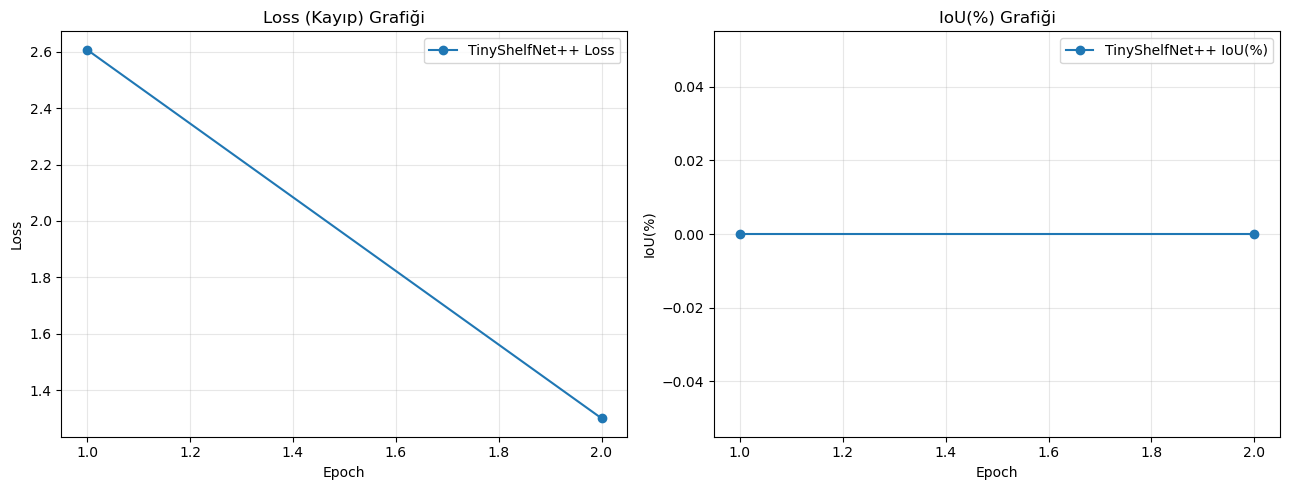

In [184]:
epochs = np.arange(1, len(hist["train_loss"])+1)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(epochs, hist["train_loss"], marker="o", label="TinyShelfNet++ Loss")
plt.title("Loss (Kayıp) Grafiği")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, hist["val_iou"], marker="o", label="TinyShelfNet++ IoU(%)")
plt.title("IoU(%) Grafiği")
plt.xlabel("Epoch")
plt.ylabel("IoU(%)")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


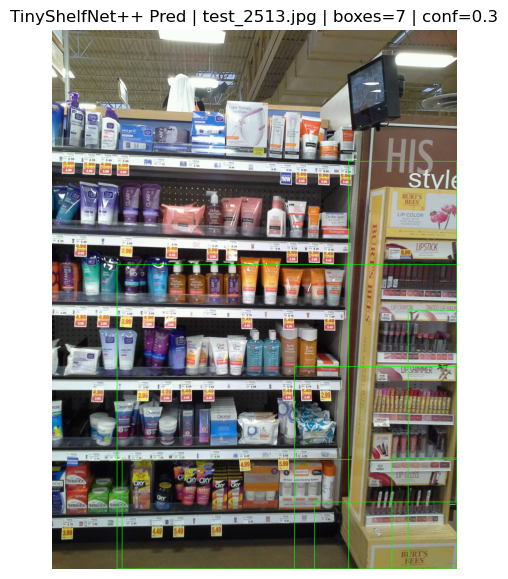

Pred box sayısı: 7


In [189]:
# rapor için daha çok kutu görmek istersen geçici düşür:
CONF_THRESH = 0.30
NMS_IOU = 0.40

idx = random.randint(0, len(train_ds)-1)
x, gt, name = train_ds[idx]

img_raw = Image.open(TRAIN_IMG_DIR/name).convert("RGB")
boxes, scores = predict_one_image(model, x, conf=CONF_THRESH, nms_iou=NMS_IOU)

img_draw = img_raw.copy()
img_draw = draw_boxes_on_pil(img_draw, boxes, color=(0,255,0), scores=scores)

plt.figure(figsize=(12,7))
plt.imshow(img_draw)
plt.axis("off")
plt.title(f"TinyShelfNet++ Pred | {name} | boxes={boxes.shape[0]} | conf={CONF_THRESH}")
plt.show()

print("Pred box sayısı:", boxes.shape[0])


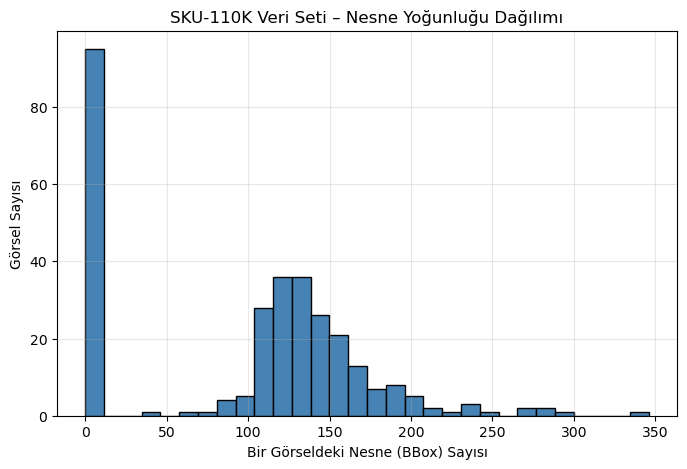

Ortalama bbox: 98.55
Maks bbox: 346


In [187]:
# 📊 Histogram: Görsel başına nesne (bbox) sayısı

bbox_counts = []

# sadece subset üstünden alalım (hızlı olsun)
for i in range(len(train_small)):
    _, boxes, _ = train_small[i]
    bbox_counts.append(len(boxes))

plt.figure(figsize=(8,5))
plt.hist(bbox_counts, bins=30, color="steelblue", edgecolor="black")
plt.xlabel("Bir Görseldeki Nesne (BBox) Sayısı")
plt.ylabel("Görsel Sayısı")
plt.title("SKU-110K Veri Seti – Nesne Yoğunluğu Dağılımı")
plt.grid(alpha=0.3)
plt.show()

print("Ortalama bbox:", np.mean(bbox_counts))
print("Maks bbox:", np.max(bbox_counts))
